In [1]:
import os
import csv
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress
import scipy.stats as st
%matplotlib notebook

In [2]:
cameras_file = os.path.join("../Desktop/Archive", "red-light-camera-locations.csv")
speedings_file = os.path.join("../Desktop/Archive","speed-camera-violations.csv")

In [3]:
red_locs_df = pd.read_csv(cameras_file)
del red_locs_df["Third Approach"]
speedings_df = pd.read_csv(speedings_file)

In [4]:
cams_per_ward = pd.DataFrame(red_locs_df.groupby("Wards")["Intersection"].count())
cams_per_ward

,Intersection
Wards,
1,2
2,2
3,2
4,1
5,1
6,1
7,4
8,4
9,1


In [5]:
violations_per_ward = pd.DataFrame(speedings_df.groupby("Wards")["Violations"].sum())
violations_per_ward.head()

,Violations
Wards,
1.0,133599
2.0,80740
3.0,76211
4.0,332224
6.0,24005


In [6]:
merge_df = pd.merge(cams_per_ward, violations_per_ward, on="Wards")
merge_df = merge_df.rename(columns={
    "Intersection": "Number of Red Light Cams per Ward",
    "Violations": "Number of Speeding Violations per Ward"
})
merge_df

,Number of Red Light Cams per Ward,Number of Speeding Violations per Ward
Wards,,
1,2,133599
2,2,80740
3,2,76211
4,1,332224
6,1,24005
7,4,162942
8,4,112003
10,1,117485
11,2,8872


In [7]:
def to_linear_regress(x, y, weight, arrangement, cmap):
    pearson_r = round(st.pearsonr(x, y)[0],2)
    (slope, intercept, rvalue, pvalue, stderr) = linregress(x, y)
    regress_values = x * slope + intercept
    line_eq = f"y = {round(slope,2)}x + {round(intercept, 2)}"
    plt.scatter(x, y, s=weight, c=arrangement, cmap=cmap)
    plt.plot(x,regress_values,"r-")
    print(f"correlation coefficient : {pearson_r}")
    return line_eq

In [8]:
def to_annotate(line_eq, x, y):
    plt.annotate(line_eq,(x,y),fontsize=13,color="red")

<IPython.core.display.Javascript object>


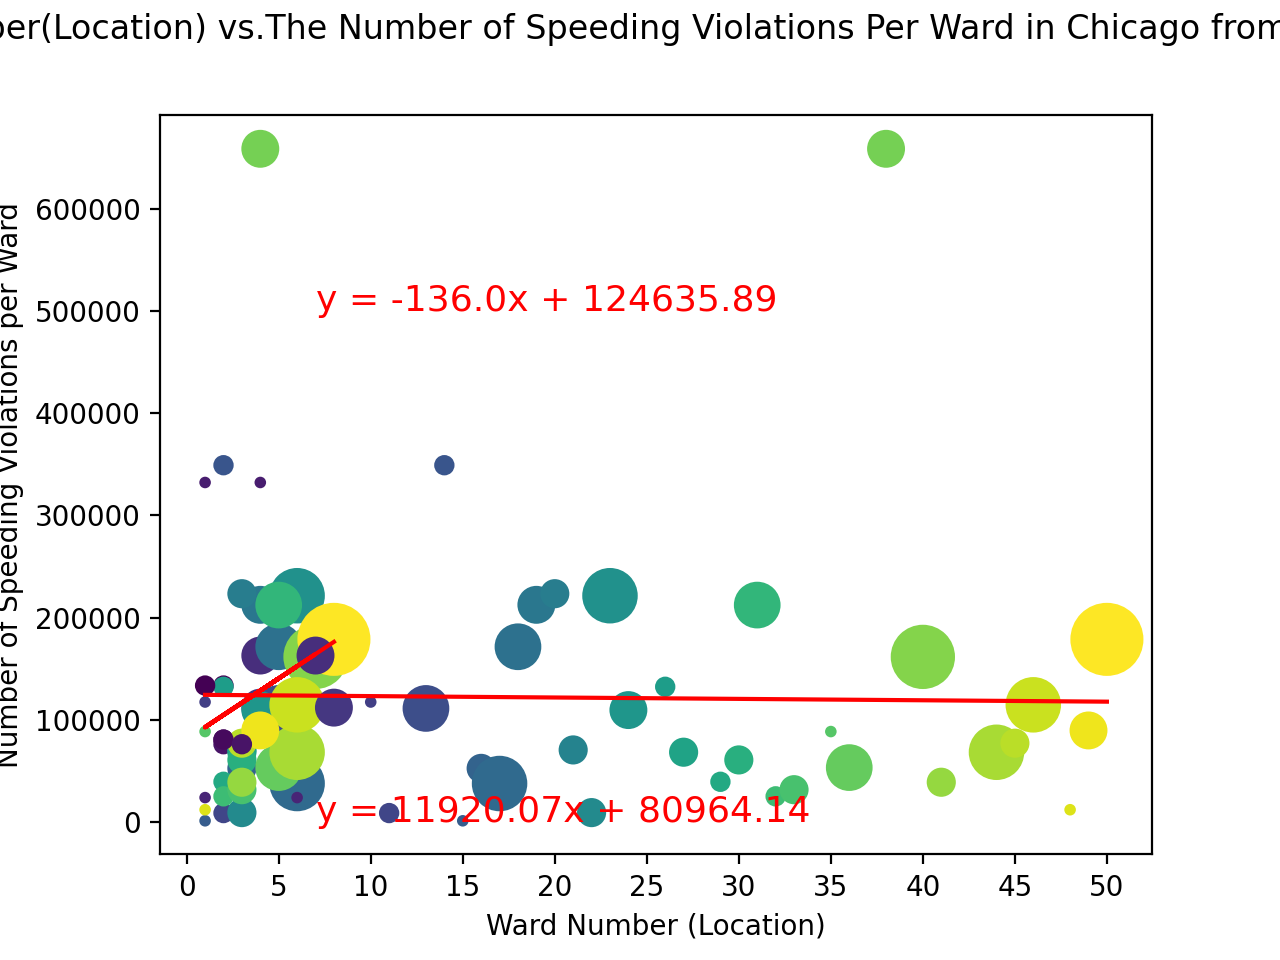

correlation coefficient : 0.18


Text(0.5, 1.08, 'Number of Red-Light Cameras Per Ward vs.The Number of Speeding Violations Per Ward in Chicago from 2014 - 2019')

In [9]:
weight= 10 * (merge_df["Number of Red Light Cams per Ward"]**2)
arrangement=np.arange(len(merge_df["Number of Red Light Cams per Ward"]))
cmap='viridis' 
line = to_linear_regress(merge_df["Number of Red Light Cams per Ward"], merge_df["Number of Speeding Violations per Ward"], weight, arrangement, cmap)
to_annotate(line, 7, 200)
plt.xlabel("Number of Red-Light Cams Per Ward")
plt.ylabel("Number of Speeding Violations per Ward")
plt.title("Number of Red-Light Cameras Per Ward vs.The Number of Speeding Violations Per Ward in Chicago from 2014 - 2019", y=1.08)

In [10]:
clean_df = merge_df.copy()

In [11]:
wards = [1,2,3,4,6,7,8,10,11,13,14,15,16,17,18,19,20,21,22,23,24,26,27,29,30,31,32,33,35,36,38,40,41,44,45,46,48,49,50] 

In [12]:
clean_df["Ward Number"] = wards

In [13]:
clean_df

,Number of Red Light Cams per Ward,Number of Speeding Violations per Ward,Ward Number
Wards,,,
1,2,133599,1
2,2,80740,2
3,2,76211,3
4,1,332224,4
6,1,24005,6
7,4,162942,7
8,4,112003,8
10,1,117485,10
11,2,8872,11


In [14]:
weight= 10 * (clean_df["Number of Red Light Cams per Ward"]**2)
arrangement=np.arange(len(clean_df["Number of Red Light Cams per Ward"]))
cmap='viridis'
line = to_linear_regress(clean_df["Ward Number"], clean_df["Number of Speeding Violations per Ward"], weight, arrangement, cmap)
to_annotate(line, 7, 500000)
plt.xticks(np.arange(0, 51, 5))
plt.xlabel("Ward Number (Location)")
plt.ylabel("Number of Speeding Violations per Ward")
plt.title("Ward Number(Location) vs.The Number of Speeding Violations Per Ward in Chicago from 2014 - 2019", y=1.08)

correlation coefficient : -0.02


Text(0.5, 1.08, 'Ward Number(Location) vs.The Number of Speeding Violations Per Ward in Chicago from 2014 - 2019')

<IPython.core.display.Javascript object>


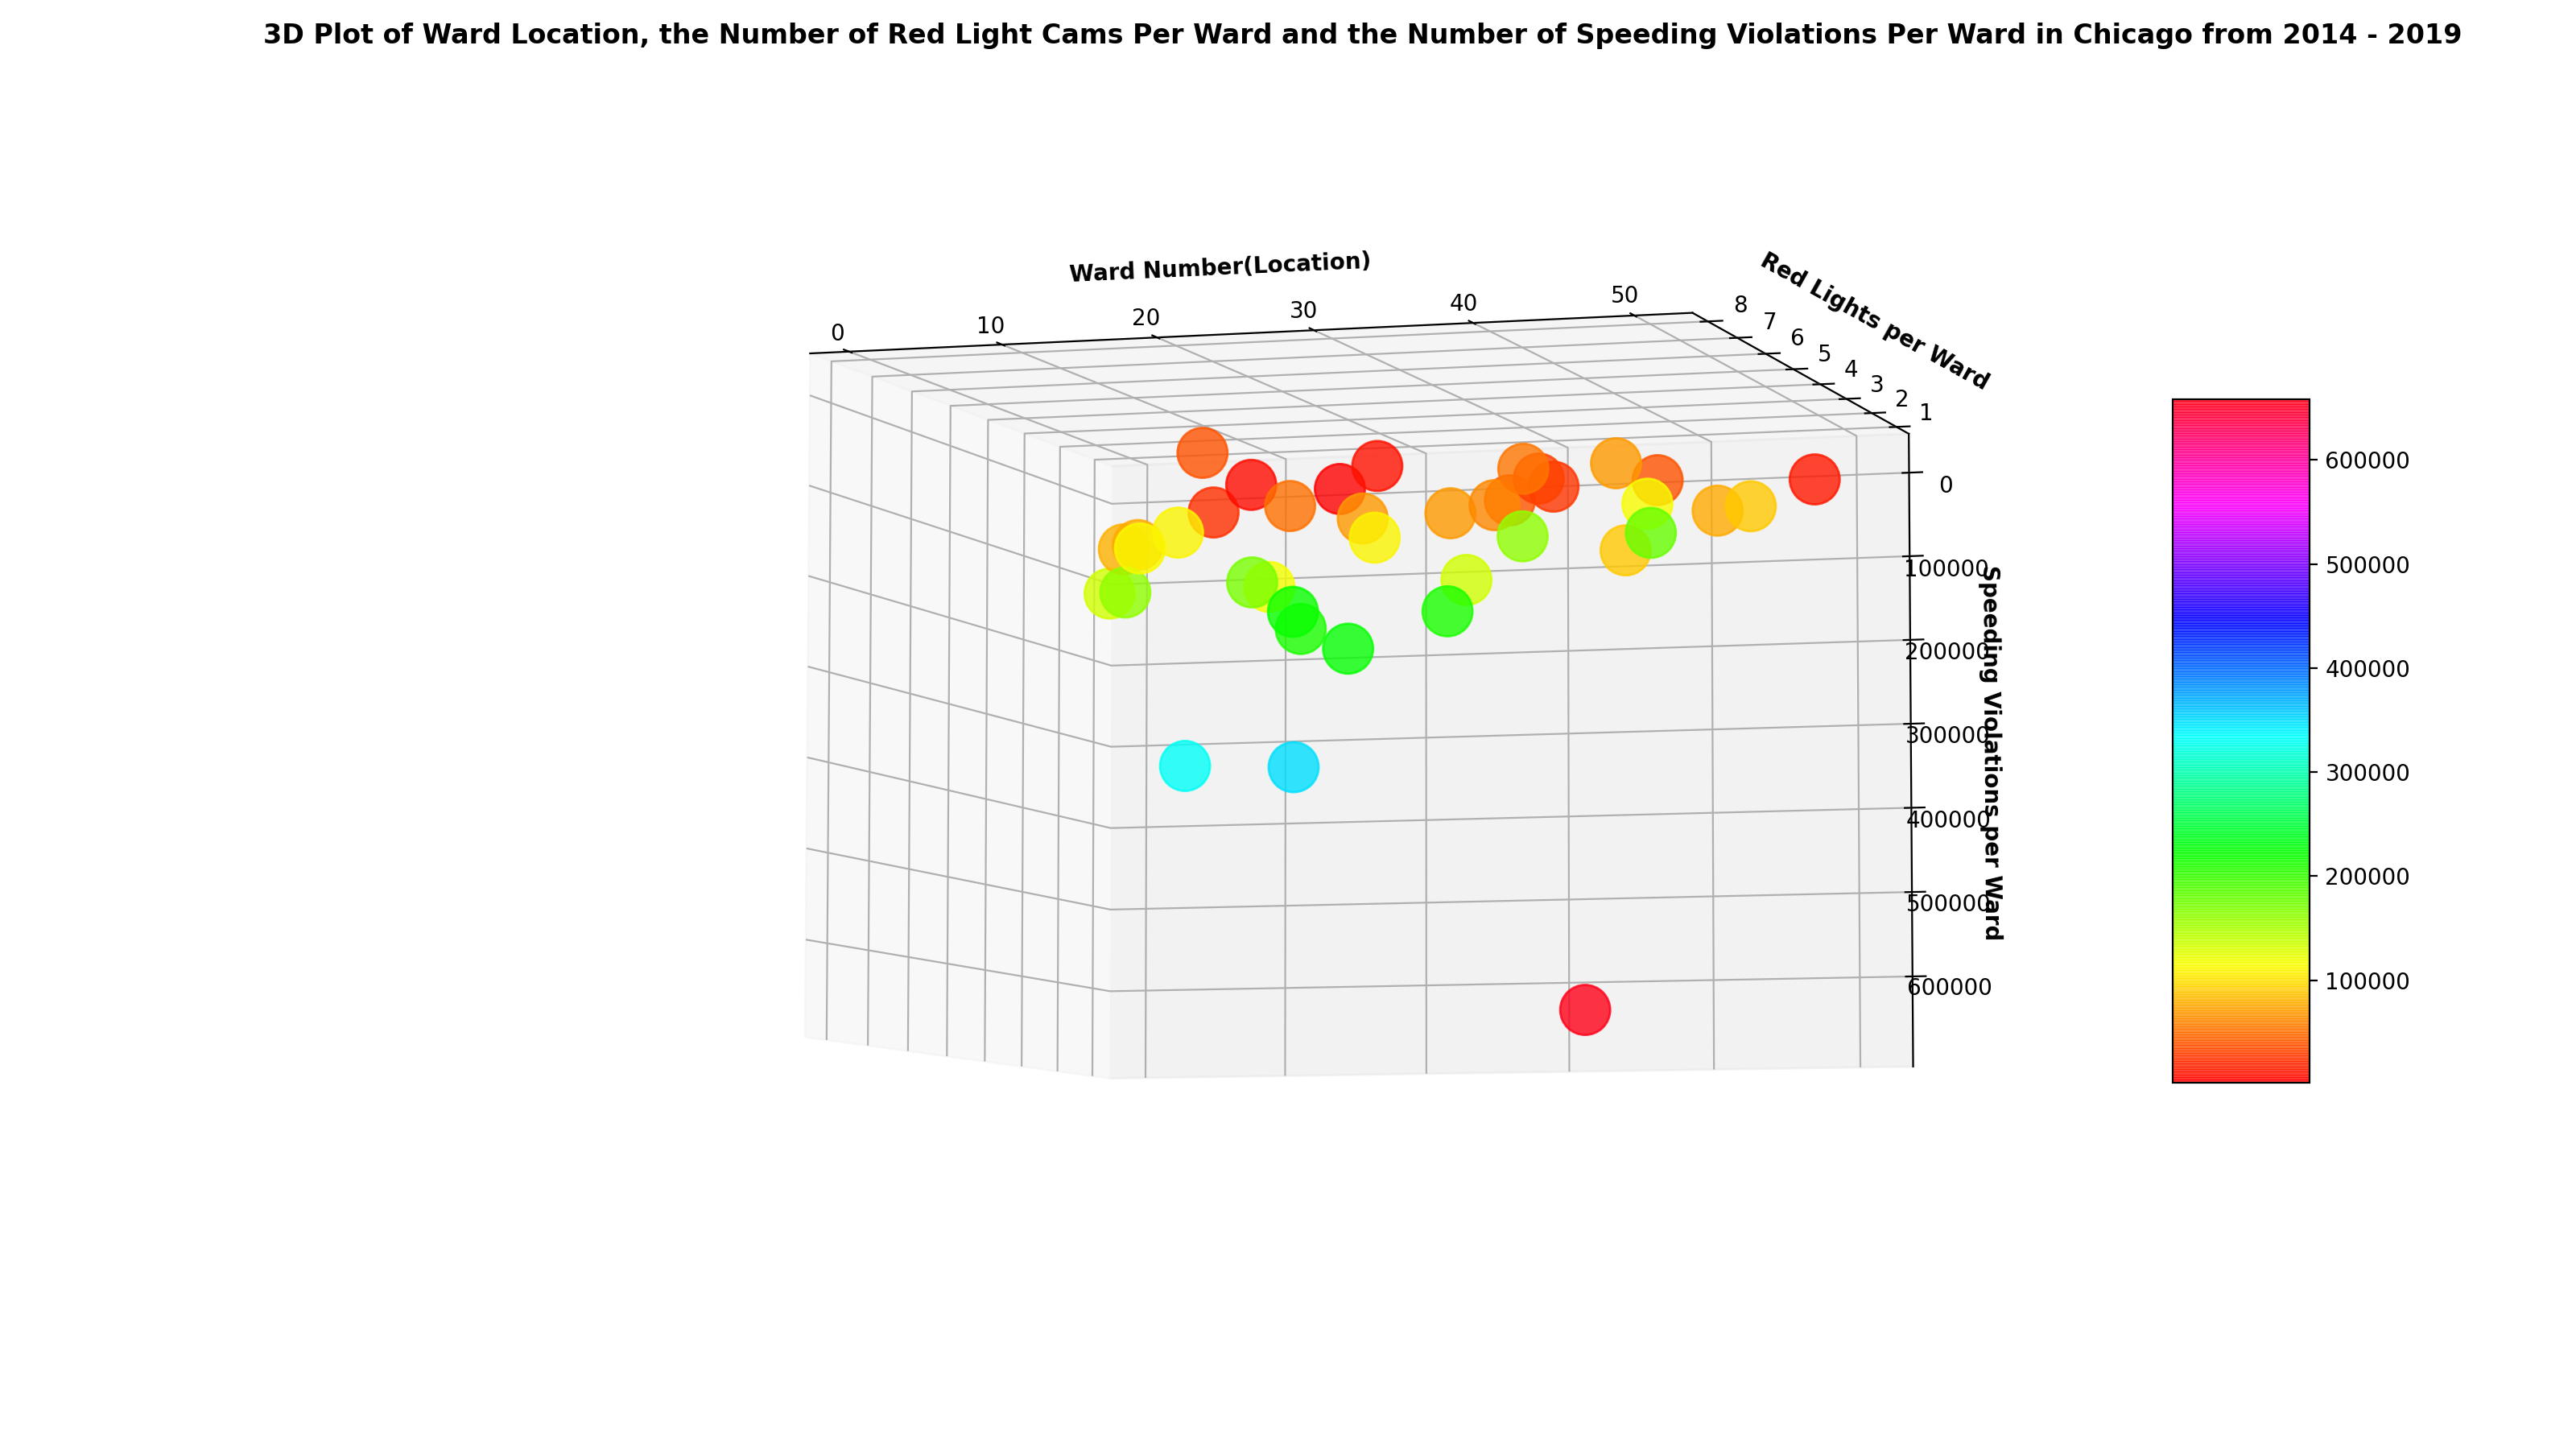

In [15]:
# Creating dataset
Number_Of_Speeding_Violations_Per_Ward = clean_df["Number of Speeding Violations per Ward"]
Ward_Number = clean_df["Ward Number"]
Red_Cams_Per_Ward = clean_df["Number of Red Light Cams per Ward"]
 
# Creating figure
fig = plt.figure(figsize = (16, 9))
ax = plt.axes(projection ="3d")
   
# Add x, y gridlines 
ax.grid(b = True, color ='grey', 
        linestyle ='-.', linewidth = 0.3, 
        alpha = 0.2) 
 
 
# Creating color map
my_cmap = plt.get_cmap('hsv')
 
# Creating plot
sctt = ax.scatter3D(Ward_Number , Red_Cams_Per_Ward, Number_Of_Speeding_Violations_Per_Ward ,
                    alpha = 0.8,
                    s=500,
                    c = (Ward_Number+ Red_Cams_Per_Ward + Number_Of_Speeding_Violations_Per_Ward),  
                    cmap = my_cmap, 
                    marker ='o')
 
plt.title("3D Plot of Ward Location, the Number of Red Light Cams Per Ward and the Number of Speeding Violations Per Ward in Chicago from 2014 - 2019", fontweight="bold")
ax.set_xlabel("Ward Number(Location)", fontweight ='bold') 
ax.set_ylabel('Red Lights per Ward',fontweight ='bold') 
ax.set_zlabel('Speeding Violations per Ward',fontweight ='bold')
fig.colorbar(sctt, ax = ax, shrink = 0.5, aspect = 5)

plt.tight_layout()
plt.show()